In [9]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm, ttest_ind_from_stats
from scipy.optimize import curve_fit

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.analysis.align import ImageAlign
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [10]:
# load trace files from the following directory
data_dir = '/home/john/Desktop/'
#data_dir = "C:/Users/jjudge3/Desktop/Data/PV-PPR/"
export_csv = data_dir + 'export_summary_anna_ppr.csv'

camera_program = 4
um_per_px = 6.875 #um
output_fig_dir = 'P:/John/crossing-paper/input/'

# load the CSVs
ppr_df = pd.read_csv(export_csv)

# add column for Coronal/Sagittal
ppr_df['Section'] = 'Coronal'

ppr_df

,ROI,amp,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Section
0,1,4.099631,54.555977,3.723524,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
1,2,4.757419,51.886871,5.262307,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
2,3,4.963872,54.517873,2.558036,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
3,4,3.655664,45.628770,13.529550,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
4,5,3.455473,54.276568,3.684579,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
...,...,...,...,...,...,...,...,...,...,...,...,...
27885,80,7.793649,151.680974,8.178213,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
27886,81,7.823825,152.926339,7.239760,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
27887,82,8.482228,153.029404,6.181901,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal
27888,83,9.894656,151.782261,7.638720,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal


In [11]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}/{d}/20{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df

FileNotFoundError: [Errno 2] No such file or directory: '/home/john/Desktop/ppr_catalog.csv'

In [ ]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

# drop all IPIs <= 10 ms
ppr_df = ppr_df[ppr_df['IPI'] > 10]

ppr_df

NameError: name 'ppr_catalog_df' is not defined

In [13]:

# label pulse number based on "pulse1" and "pulse2" substring in the "ROI_Set" column
def label_pulse(roi_set):
    if 'pulse1' in roi_set:
        return 1
    elif 'pulse2' in roi_set:
        return 2
    else:
        return None
ppr_df['Pulse_Number'] = ppr_df['ROI_Set'].apply(label_pulse)
ppr_df

,ROI,amp,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,trace,amp_array,Section,Pulse_Number
0,1,4.099631,54.555977,3.723524,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,1
1,2,4.757419,51.886871,5.262307,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,1
2,3,4.963872,54.517873,2.558036,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,1
3,4,3.655664,45.628770,13.529550,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,1
4,5,3.455473,54.276568,3.684579,02_01_ROIs_1_to_26 pulse1,22-9-2,2,1,2,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27885,80,7.793649,151.680974,8.178213,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,2
27886,81,7.823825,152.926339,7.239760,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,2
27887,82,8.482228,153.029404,6.181901,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,2
27888,83,9.894656,151.782261,7.638720,07_02_ROIs_1_to_84 pulse2,23-6-30,7,2,3,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...,Coronal,2


In [ ]:
ppr_df['PPR'] = np.nan
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slice_df = date_df[date_df['Slice'] == slic]
        for location in slice_df['Location'].unique():
            location_df = slice_df[slice_df['Location'] == location]
            for recording in location_df['Recording'].unique():
                recording_df = location_df[location_df['Recording'] == recording]
                for roi in recording_df['ROI'].unique():
                    roi_df = recording_df[recording_df['ROI'] == roi]
                    if len(roi_df) != 2:
                        print(f"Warning: {date} Slice {slic} Location {location} Recording {recording} ROI {roi} does not have 2 pulses.")
                        print(roi_df)
                        continue
                    pulse1_df = roi_df[roi_df['Pulse_Number'] == 1]
                    pulse2_df = roi_df[roi_df['Pulse_Number'] == 2]
                    ppr = pulse2_df['amp'].values[0] / pulse1_df['amp'].values[0] if \
                        pulse1_df['amp'].values[0] != 0 else np.nan
                    ppr_df.loc[roi_df.index, 'PPR'] = ppr
ppr_df['PPR'] = ppr_df['PPR'].astype(float)

# print unique non-nan ppr values
print(ppr_df['PPR'].dropna().unique())
ppr_df

    ROI       amp    latency  halfwidth                    ROI_Set    Date  \
0     1  4.099631  54.555977   3.723524  02_01_ROIs_1_to_26 pulse1  22-9-2   
26    1  2.457498  93.000000  31.008565  02_01_ROIs_1_to_26 pulse2  22-9-2   

    Slice  Location  Recording  \
0       2         1          2   
26      2         1          2   

                                                trace  \
0   C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...   
26  C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...   

                                            amp_array  Section  Pulse_Number  \
0   C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...  Coronal             1   
26  C:/Users/jjudge3/Desktop/Data/PV-PPR/AnnaJ-PPR...  Coronal             2   

    PPR  
0   NaN  
26  NaN  
    ROI       amp    latency  halfwidth                    ROI_Set    Date  \
1     2  4.757419  51.886871   5.262307  02_01_ROIs_1_to_26 pulse1  22-9-2   
27    2  3.606988  98.444678   9.005094  02_01_ROIs_1_to_26 pul

Quality of fit for Medial:
R = 0.44871567347843594
R^2 = 0.20134575562520635
p-value = 3.703472636092031e-07
1-a = 0.5846179719537065
b = 234.67559442918068
PPR at IPI = 20 ms = 0.6185519700578244
a uncertainty = 0.08431408629732898
b uncertainty = 152.70616950410377
Quality of fit for Lateral:
R = 0.36936121473413186
R^2 = 0.13642770694987347
p-value = 3.780244313261717e-07
1-a = 0.7280642942053525
b = 268.930649401593
PPR at IPI = 20 ms = 0.7475540800579515
a uncertainty = 0.0646369141219393
b uncertainty = 231.19415216382012


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21060\416810107.py:135: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax[0].legend(handles=handles[:3], labels=[


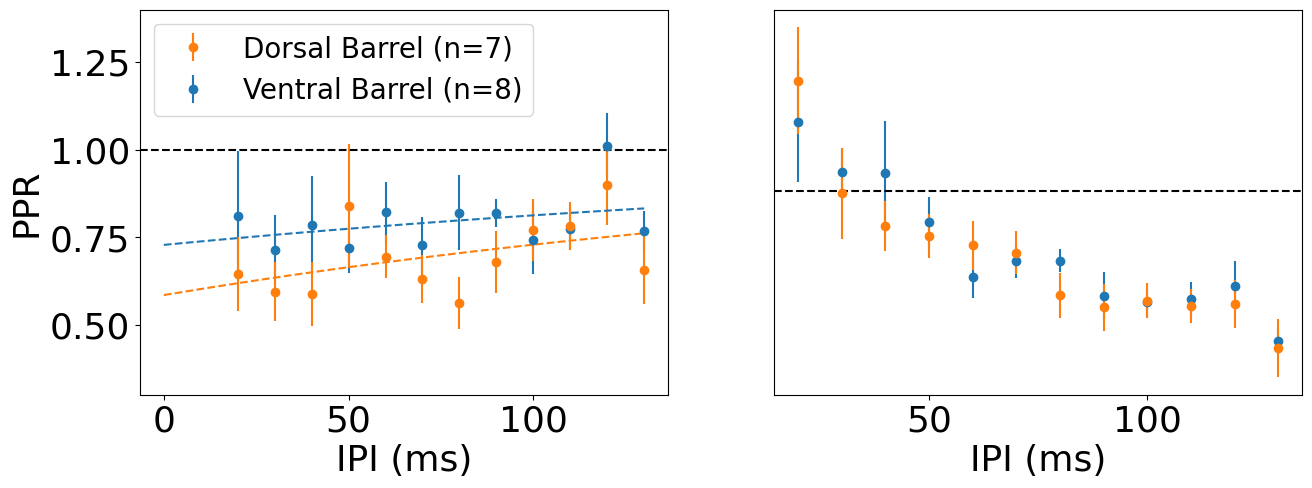

Quality of fit for Rostral:
R = 0.527272329924472
R^2 = 0.2780161099039813
p-value = 3.835974549637399e-07
1-a = 0.7347573342958937
b = 109.55514113059223
PPR at IPI = 20 ms = 0.7790163636515495
a uncertainty = 0.11745984162280682
b uncertainty = 84.53083047917178
Quality of fit for Caudal:
R = -0.04151982904675823
R^2 = 0.0017238962040720285
p-value = 3.81116075497825e-07
1-a = 0.8312821219731731
b = 172521253.8596274
PPR at IPI = 20 ms = 0.8312821415322551
a uncertainty = 0.06693406497513626
b uncertainty = 96249142799222.48


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_21060\416810107.py:135: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  ax[0].legend(handles=handles[:3], labels=[


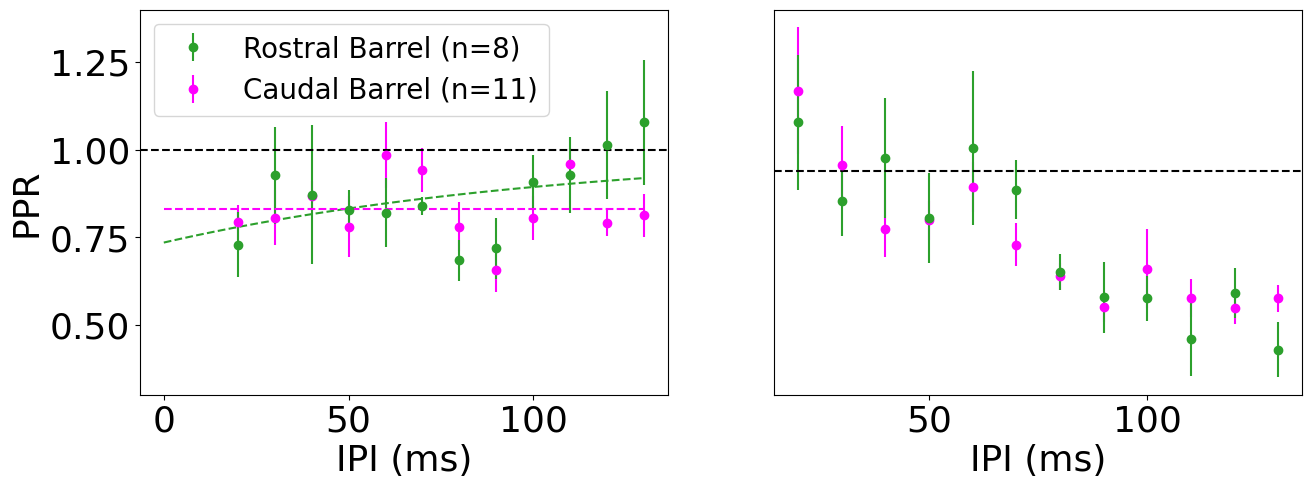

In [ ]:
# plot the PPR and PPR Composed, separated by IPI, separated 
# for home barrel (ROI = 1), medial barrel, and lateral barrel (Medial/Lateral columns)
# group by IPI, and Medial/Lateral columns
plt.rcParams.update({'font.size': 26})

# initialize empty dataframe with PPR, IPI, Medial_Lateral, Rostral_Caudal, and Section
# record only the data that makes it into the final plot
ppr_final_df = pd.DataFrame(columns=['Date', 'PPR', 'PPR Composed', 'IPI', 'Direction', 'Section'])

directions_by_section = {"Coronal": "Medial/Lateral", "Sagittal": "Rostral/Caudal"}
sections = ['Coronal', 'Sagittal']
for section in sections:
    directions = directions_by_section[section].split('/')
    ppr_df_section = ppr_df[ppr_df['Section'] == section]
    ppr_coronal_grouped = ppr_df_section.groupby(['IPI', directions_by_section[section]])
    handles = [None, None, None]
    # plot PPR and PPR Composed
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    mean_ppr_vs_ipi = {
        directions[0]: [[],[]],
        directions[1]: [[],[]],
        'Home Barrel': [[],[]]
    }
    for (ipi, direction), group in ppr_coronal_grouped:
        color = 'tab:green' if direction == "Rostral" else 'magenta' if direction == "Caudal" else \
                'tab:blue' if direction == "Lateral" else 'tab:orange' if direction == "Medial" else 'black'
        #group = group.dropna()
        # plot as scatter plot with error bars
        # include only values from 0 - 2
        group_ppr = group[(group['PPR'] > 0) & (group['PPR'] < 2.5)]

        mean_key = 'Home Barrel' if direction not in directions else direction
        if mean_key == 'Home Barrel':
            continue  # skip home barrel

        mean_ppr_vs_ipi[mean_key][0].append(group_ppr['PPR'].mean())
        mean_ppr_vs_ipi[mean_key][1].append(ipi)
        h = ax[0].errorbar(ipi, group_ppr['PPR'].mean(), yerr=sem(group_ppr['PPR']), fmt='o', label=direction, color=color)

        # add the filtered data to the final dataframe ppr_final_df
        ppr_final_df = pd.concat([ppr_final_df, group_ppr[['Date', 'PPR', 'PPR Composed', 'IPI', 
                    directions_by_section[section], 'Section']].rename(columns={directions_by_section[section]: 'Direction'})])

        if direction == directions[0]:
            handles[0] = h
        elif direction == directions[1]:
            handles[1] = h
        else:
            handles[2] = h

        group_ppr_composed = group[(group['PPR Composed'] > 0) & (group['PPR Composed'] < 2.5)]
        ax[1].errorbar(ipi, group_ppr_composed['PPR Composed'].mean(), 
                        yerr=sem(group_ppr_composed['PPR Composed']), color=color, 
                        fmt='o', label=direction)

        # label the sample size for each point on the PPR composed plot
        '''ax[1].annotate(f"n={len(group_ppr_composed)}", 
                    (ipi-5, 
                            (-.3 if direction == directions[0] else .1 if direction == directions[1] else -.6) +
                            group_ppr_composed['PPR Composed'].mean()+
                            sem(group_ppr_composed['PPR Composed'])
                            ), color=color)'''

    # add an expoential fit to the PPR plot using the data in mean_ppr_vs_ipi
    # fit the data to an exponential function
    def exp_fit_2(x, a, b, c, d, e):
        return a * np.exp(b * x) + c * np.sin(d * x + e)

    def exp_fit(x, a, b, d):
        return a * np.exp(x / b)  + d

    def lin_fit(x, a, b):
        return a * x + b

    def exp_fit_3(x, a, b):
        return (1 - a *  np.exp(- x / b))

    for dir in mean_ppr_vs_ipi.keys():
        color = 'tab:green' if dir == "Rostral" else 'magenta' if dir == "Caudal" else \
                'tab:blue' if dir == "Lateral" else 'tab:orange' if dir == "Medial" else 'black'
        if dir == 'Home Barrel':
            continue
        # fit the data to an exponential function
        x_data = np.array(mean_ppr_vs_ipi[dir][1])
        y_data = np.array(mean_ppr_vs_ipi[dir][0])
        # fit the data to an exponential function
        # p0 = (0.5, -20000, 1) # exp_fit
        p0 = (0.5, 200)  # exp_fit_3
        exp_fit_ = exp_fit_3
        #if section == section[0]:
        #    exp_fit_ = exp_fit_2
        p0_exp = (0.5, -0.1, 1, 0.1, 0.1)
        p0_lin = [0.1/100, 0.6]
        popt, pcov = curve_fit(exp_fit_, x_data, y_data, p0=p0, maxfev=10000)
        # plot the fit
        x_fit = np.linspace(0, 130, 120)
        y_fit = exp_fit_(x_fit, *popt)
        ax[0].plot(x_fit, y_fit, color=color, linestyle='--')

        # quality of fit
        print(f"Quality of fit for {dir}:")
        print("R =", np.corrcoef(x_data, y_data)[0, 1])
        print("R^2 =", np.corrcoef(x_data, y_data)[0, 1]**2)
        print("p-value =", ttest_ind(x_data, y_data)[1])
        print("1-a =", 1-popt[0])
        print("b =", popt[1])
        #print("c =", popt[2])

        # print the PPR at IPI = 20 ms
        ppr_20 = exp_fit_(20, *popt)
        print("PPR at IPI = 20 ms =", ppr_20)

        # uncertainty of slope and intercept
        slope_uncertainty = np.sqrt(pcov[0][0])
        intercept_uncertainty = np.sqrt(pcov[1][1])
        print("a uncertainty =", slope_uncertainty)
        print("b uncertainty =", intercept_uncertainty)

    # calculate the sample size, one for each IPI group, and take the mode
    try:
        n_home = ppr_df_section[(ppr_df_section[directions_by_section[section]] != directions[0]) & 
                                (ppr_df_section[directions_by_section[section]] != directions[1])].groupby('IPI').size().mode().values[0]
    except IndexError:
        n_home = 0
    try:
        n_medial = ppr_df_section[ppr_df_section[directions_by_section[section]] == directions[0]].groupby('IPI').size().mode().values[0]
    except IndexError:
        n_medial = 0
    try:
        n_lateral = ppr_df_section[ppr_df_section[directions_by_section[section]] == directions[1]].groupby('IPI').size().mode().values[0]
    except IndexError:
        n_lateral = 0
        print(n_home, n_medial, n_lateral)
    
    ax[0].legend(handles=handles[:3], labels=[ 
                                              ("Dorsal" if "Medial" == directions[0]
                                               else "Ventral" if "Lateral" == directions[0] else directions[0]) + ' Barrel (n=' + str(n_medial) + ')',
                                              ("Dorsal" if "Medial" == directions[1]
                                               else "Ventral" if "Lateral" == directions[1] else directions[1]) + ' Barrel (n='+ str(n_lateral) +')',
                                              'Home Barrel (n=' + str(n_home) + ')'],
                                              loc='upper left', fontsize=20)
    ax[0].set_ylim(0.3, 1.4)
    #ax[1].set_ylim(0.1, 2.1)
    #ax[0].set_title("PPR")
    #ax[1].set_title("PPR Raw")
    ax[0].set_xlabel("IPI (ms)")
    ax[1].set_xlabel("IPI (ms)")
    ax[0].set_ylabel("PPR")
    ax[1].set_yticks([])

    # horizontal line at 1 for reference
    ax[0].axhline(1, color='black', linestyle='--')
    ax[1].axhline(1, color='black', linestyle='--')

    
    plt.savefig(output_fig_dir + "PPR_composed_" + directions_by_section[section].replace("/", "_") + ".png")
    plt.show()
    mean_ppr_vs_ipi

In [ ]:
# use ttest_ind_from_stats to see if the PPD recovery is significantly differnent
# between medial, lateral, caudal, and rostral
slope_means = {
    
}
slope_stds = {
    
}
intercept_means = {
    
}
intercept_stds = {
}

# number of tests is nC2
num_tests = 6 * 2
# calculate the t-statistic and p-value for each pair of slopes and intercepts

for i1 in range(len(dir)):
    dir1 = dir[i1]
    for i2 in range(i1+1, len(dir)):
        dir2 = dir[i2]
        if dir1 == dir2:
            continue
        slope_tstat, slope_pval = ttest_ind_from_stats(slope_means[dir1], slope_stds[dir1], 10, 
                                                        slope_means[dir2], slope_stds[dir2], 10,
                                                        equal_var=False)
        intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means[dir1], intercept_stds[dir1], 10, 
                                                                intercept_means[dir2], intercept_stds[dir2], 10,
                                                                equal_var=False)
        if slope_pval * num_tests < 0.05:
            print(f"\n{dir1} vs {dir2}:")
            print("Slope t-statistic =", round(slope_tstat, 2))
            print("Slope p-value =", slope_pval)
        if intercept_pval * num_tests < 0.05:
            print(f"\n{dir1} vs {dir2}:")
            print("Intercept t-statistic =", round(intercept_tstat, 2))
            print("Intercept p-value =", intercept_pval)


Medial vs Lateral:
Intercept t-statistic = -5.51
Intercept p-value = 4.4224019120746885e-05

Medial vs Caudal:
Slope t-statistic = 5.42
Slope p-value = 3.7556775078123506e-05

Medial vs Caudal:
Intercept t-statistic = -4.79
Intercept p-value = 0.00014605978372262543

Medial vs Rostral:
Intercept t-statistic = -7.99
Intercept p-value = 2.512792154633548e-07

Lateral vs Caudal:
Slope t-statistic = 3.47
Slope p-value = 0.0027577115509008366

Lateral vs Rostral:
Intercept t-statistic = -3.68
Intercept p-value = 0.0019911244714741418


In [ ]:

def anova_time_constants(data, var='Time_Constant'):
    model = ols(var + ' ~ C(Direction)', data=data).fit()
    anova_results = anova_lm(model, typ=2)
    return anova_results

time_constants_means = {
    "Dorsal": 235,
    "Ventral": 269,
    "Rostral": 110,
}
time_constants_sems = {
    "Dorsal": 150,
    "Ventral": 230,
    "Rostral": 85,
}
time_constants_n = {
    "Dorsal": 7,
    "Ventral": 8,
    "Rostral": 11,
    "Caudal": 8
}
# simulate the data for ANOVA
anova_data = {}
for direction in ['Dorsal', 'Ventral', 'Rostral']:
    mean = time_constants_means[direction]
    sem = time_constants_sems[direction]
    n = time_constants_n[direction]
    # generate random data based on mean and sem
    anova_data[direction] = np.random.normal(mean, sem, n)

anova_df = pd.DataFrame({
    'Time_Constant': np.concatenate(list(anova_data.values())),
    'Direction': ['Dorsal'] * len(anova_data['Dorsal']) + ['Ventral'] * len(anova_data['Ventral']) + ['Rostral'] * len(anova_data['Rostral'])
})

anova_results = anova_time_constants(anova_df)
print(anova_results)

# ttest_ind_from_stats for time constants
for i1 in range(len(time_constants_means)):
    dir1 = list(time_constants_means.keys())[i1]
    for i2 in range(i1+1, len(time_constants_means)):
        dir2 = list(time_constants_means.keys())[i2]
        if dir1 == dir2:
            continue
        time_constant_tstat, time_constant_pval = ttest_ind_from_stats(
            time_constants_means[dir1], time_constants_sems[dir1], time_constants_n[dir1],
            time_constants_means[dir2], time_constants_sems[dir2], time_constants_n[dir2],
            equal_var=False
        )
        print(f"\n{dir1} vs {dir2}:")
        print("Time Constant t-statistic =", round(time_constant_tstat, 2))
        print("Time Constant p-value =", time_constant_pval)

# Tukey's HSD test for multiple comparisons
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=anova_df['Time_Constant'], groups=anova_df['Direction'], alpha=0.05)
print(tukey)

                     sum_sq    df         F    PR(>F)
C(Direction)   71145.543146   2.0  1.315724  0.287726
Residual      621842.780626  23.0       NaN       NaN

Dorsal vs Ventral:
Time Constant t-statistic = -0.34
Time Constant p-value = 0.7374871585054672

Dorsal vs Rostral:
Time Constant t-statistic = 2.01
Time Constant p-value = 0.07734066184286946

Ventral vs Rostral:
Time Constant t-statistic = 1.86
Time Constant p-value = 0.09741591285023916
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj    lower    upper   reject
----------------------------------------------------------
 Dorsal Rostral -119.2857 0.3096  -318.335  79.7636  False
 Dorsal Ventral  -29.8211    0.9 -242.8906 183.2485  False
Rostral Ventral   89.4646 0.4833 -101.8311 280.7603  False
----------------------------------------------------------


In [ ]:
ppr_intercepts_means = {
    }

ppr_intercepts_sems = {
    }

ppr_intercepts_n = time_constants_n

# anova for PPR intercepts
anova_ppr_data = {}
for direction in ppr_intercepts_means.keys():
    mean = ppr_intercepts_means[direction]
    sem = ppr_intercepts_sems[direction]
    n = ppr_intercepts_n[direction]
    # generate random data based on mean and sem
    anova_ppr_data[direction] = np.random.normal(mean, sem, n)

anova_ppr_df = pd.DataFrame({
    'PPR_Intercept': np.concatenate(list(anova_ppr_data.values())),
    'Direction': ['Dorsal'] * len(anova_ppr_data['Dorsal']) + 
                 ['Ventral'] * len(anova_ppr_data['Ventral']) + 
                 ['Rostral'] * len(anova_ppr_data['Rostral']) +
                 ['Caudal'] * len(anova_ppr_data['Caudal'])
})
anova_ppr_results = anova_time_constants(anova_ppr_df, var='PPR_Intercept')
print(anova_ppr_results)

# Tukey's HSD test for multiple comparisons
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=anova_ppr_df['PPR_Intercept'], groups=anova_ppr_df['Direction'], alpha=0.05)
print(tukey)

                sum_sq    df         F   PR(>F)
C(Direction)  0.265812   3.0  8.672689  0.00027
Residual      0.306493  30.0       NaN      NaN
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 Caudal  Dorsal  -0.2649  0.001 -0.4071 -0.1226   True
 Caudal Rostral  -0.0997 0.1689 -0.2274   0.028  False
 Caudal Ventral  -0.1066 0.1732  -0.244  0.0308  False
 Dorsal Rostral   0.1651 0.0104  0.0322   0.298   True
 Dorsal Ventral   0.1582 0.0247   0.016  0.3005   True
Rostral Ventral  -0.0069    0.9 -0.1346  0.1208  False
------------------------------------------------------


In [ ]:
# 2-way ANOVA for PPR vs IPI and Direction
model = ols('PPR ~ IPI * C(Direction) + IPI:C(Direction)', data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Direction),26.684122,4.0,1.024229,0.393895
IPI,34.623926,1.0,5.315945,0.021437
IPI:C(Direction),84.274532,4.0,3.234748,0.012114
Residual,4350.832117,668.0,NaN,NaN


In [ ]:
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
model = ols('PPR ~ IPI + C(Medial_Lateral) + IPI:C(Medial_Lateral)', 
                data=ppr_df[(ppr_df['Medial_Lateral'] != 'Home') & (ppr_df['Section'] == 'Coronal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Medial_Lateral),5.053844,1.0,2.928850,0.088812
IPI,4.283647,1.0,2.482498,0.116957
IPI:C(Medial_Lateral),15.244388,1.0,8.834567,0.003380
Residual,296.792655,172.0,NaN,NaN


In [ ]:
# 2-way ANOVA for rostral and caudal PPR vs IPI (sagittal sections)
model = ols('PPR ~ IPI + C(Rostral_Caudal) + IPI:C(Rostral_Caudal)', 
                data=ppr_df[(ppr_df['Rostral_Caudal'] != 'Home') & (ppr_df['Section'] == 'Sagittal')]).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Rostral_Caudal),0.213399,1.0,0.165003,0.685022
IPI,0.383089,1.0,0.296209,0.586869
IPI:C(Rostral_Caudal),0.542208,1.0,0.419241,0.518051
Residual,261.248197,202.0,NaN,NaN


In [ ]:
# 2-way ANOVA for coronal and sagittal PPR vs IPI (all sections)
model = ols('PPR ~ IPI + C(Section) + IPI:C(Section)', 
                data=ppr_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(Section),38.701646,1.0,5.923185,0.015202
IPI,33.099767,1.0,5.065832,0.024724
IPI:C(Section),19.223988,1.0,2.942181,0.086754
Residual,4403.865136,674.0,NaN,NaN


In [ ]:
# load all_animals_age_sex.csv from C:\Users\jjudge3\Desktop\Data\crossing_PPR\
age_sex_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/all_animals_age_sex.csv'
age_sex_df = pd.read_csv(age_sex_csv)

# add age and sex as columns to ladder_df_nbqx, matching on Date
# Merge Age and Sex from age_sex_df into ppr_final_df using the Date column
ppr_final_df = ppr_final_df.merge(
    age_sex_df[['Date', 'Age', 'Sex']],
    on='Date',
    how='left',
    suffixes=('', '_from_age_sex')
)
ppr_final_df

,Date,PPR,PPR Composed,IPI,Direction,Section,Age,Sex
0,1/2/2025,2.191522,2.271595,20,Lateral,Coronal,52.0,M
1,1/7/2025,0.550152,0.903302,20,Lateral,Coronal,57.0,M
2,1/7/2025,0.774764,0.968513,20,Lateral,Coronal,57.0,M
3,1/7/2025,0.810284,0.777379,20,Lateral,Coronal,57.0,M
4,11/6/2024,0.483911,0.868049,20,Lateral,Coronal,46.0,M
...,...,...,...,...,...,...,...,...
395,4/9/2025,0.884616,0.827771,130,Rostral,Sagittal,43.0,F
396,4/9/2025,0.926541,0.667876,130,Rostral,Sagittal,43.0,F
397,4/16/2025,0.660833,0.616403,130,Rostral,Sagittal,41.0,F
398,4/16/2025,0.790963,0.590855,130,Rostral,Sagittal,41.0,F


In [ ]:
# ANOVA for age
# 2-way ANOVA for medial and lateral PPR vs IPI (coronal sections)
# make Age_from_age_sex a numerical column
ppr_final_df['Age_from_age_sex'] = pd.to_numeric(ppr_final_df['Age_from_age_sex'], errors='coerce')
model = ols('PPR ~ IPI + Age_from_age_sex + Sex + IPI:Age_from_age_sex + IPI:Sex + Direction', 
                data=ppr_final_df).fit()
anova_table = anova_lm(model, typ=2)
anova_table

KeyError: 'Age_from_age_sex'

Sex: M | Slope: 0.0015 ± 0.0006 | Intercept: 0.6667 ± 0.0536
           Date
0      1/2/2025
1      1/7/2025
4     11/6/2024
5    12/11/2024
7    12/20/2024
14   12/23/2024
184   1/15/2025
188    2/5/2025
Sex: M | n: 8
Sex: F | Slope: 0.0003 ± 0.0007 | Intercept: 0.7934 ± 0.0547
           Date
6    12/18/2024
186   1/22/2025
189    4/9/2025
194   4/16/2025
Sex: F | n: 4


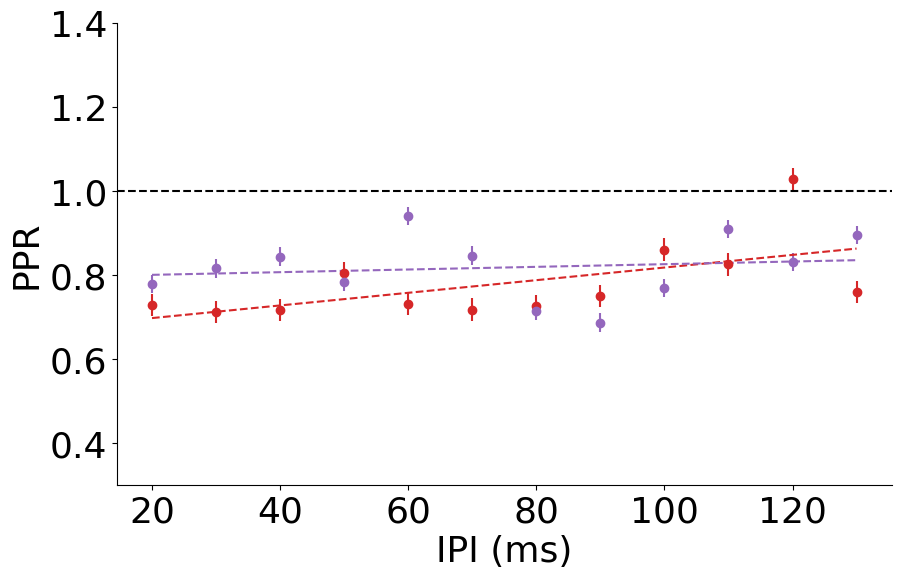

In [ ]:
# Group by Sex and then plot PPR versus IPI.

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))
# Iterate through each unique Sex value
for i_sex, sex in enumerate(ppr_final_df['Sex'].unique()):
    # Filter the DataFrame for the current sex, and for Direction not None
    sex_ppr_df = ppr_final_df[(ppr_final_df['Sex'] == sex)]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = sex_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color='tab:red' if sex == 'M' else 'tab:purple',
                label = sex, fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color='tab:red' if sex == 'M' else 'tab:purple', linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Sex: {sex} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")
    
    # print number of animals
    print(sex_ppr_df[['Date']].drop_duplicates())
    n_slices = sex_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Sex: {sex} | n: {n_slices}")

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "sex_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

Age: 45 | Slope: 0.0007 ± 0.0006 | Intercept: 0.7538 ± 0.0495
Age: 45 | n: 9
Age: 60 | Slope: 0.0007 ± 0.0005 | Intercept: 0.6980 ± 0.0384
Age: 60 | n: 2
Age: 30 | Slope: 0.0029 ± 0.0020 | Intercept: 0.6745 ± 0.1627
Age: 30 | n: 1


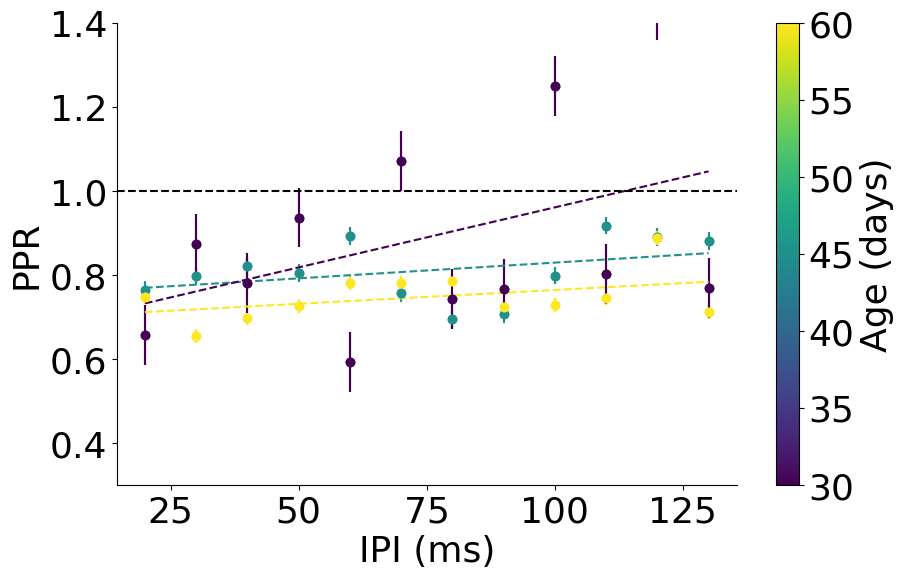

In [ ]:
# Group by Age and then plot PPR versus IPI.

# map ages to the nearest of 30, 45, or 60 days
def map_age_to_nearest(age):
    if age < 37.5:
        return 30
    elif 37.5 < age < 52.5:
        return 45
    elif age > 52.5:
        return 60
    else:
        return 60
# Apply the mapping function to the Age column
ppr_final_df['Age'] = ppr_final_df['Age'].apply(map_age_to_nearest)

# Create a new figure for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# colorbar for age
# Normalize ages for colormap
ages = ppr_final_df['Age'].unique()
ages.sort()
norm = plt.Normalize(ages.min(), ages.max())
cmap = plt.cm.viridis

# Iterate through each unique Sex value
for i_age, age in enumerate(ppr_final_df['Age'].unique()):
    # Filter the DataFrame for the current sex
    age_ppr_df = ppr_final_df[ppr_final_df['Age'] == age]
    # Group by IPI and calculate the mean PPR for each IPI
    grouped_df = age_ppr_df.groupby('IPI').mean()
    # Plot the mean PPR versus IPI for the current sex, with error bars

    # Get color for this age
    color = cmap(norm(age))
    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                fmt='o')


    ax.errorbar(grouped_df.index, grouped_df['PPR'], 
                yerr=grouped_df['PPR'].sem(),
                color=color,
                 fmt='o')

    # linear regression fit
    p0 = (0.1, 0.6)  # initial guess for slope and intercept
    popt, pcov = curve_fit(lambda x, a, b: a * x + b, 
                           grouped_df.index, 
                           grouped_df['PPR'], p0=p0, maxfev=10000)
    # plot the fit line
    x_fit = np.linspace(grouped_df.index.min(), grouped_df.index.max(), 100)
    y_fit = popt[0] * x_fit + popt[1]
    ax.plot(x_fit, y_fit, color=color, linestyle='--')
    # print the slope and intercept with uncertainty
    slope_uncertainty = np.sqrt(pcov[0][0])
    intercept_uncertainty = np.sqrt(pcov[1][1])
    print(f"Age: {age} | Slope: {popt[0]:.4f} ± {slope_uncertainty:.4f} | Intercept: {popt[1]:.4f} ± {intercept_uncertainty:.4f}")

    # print number of animals
    n_slices = age_ppr_df[['Date']].drop_duplicates().shape[0]
    print(f"Age: {age} | n: {n_slices}")


# Add colorbar to indicate age
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Age (days)')

#ax.legend()
ax.set_xlabel('IPI (ms)')
ax.set_ylabel('PPR')
ax.set_ylim(0.3, 1.4)

# dotted line at PPR = 1
ax.axhline(1, color='black', linestyle='--')

# remove spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save the figure
plt.savefig(output_fig_dir + "age_PPR_vs_IPI.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# use ttest_ind_from_stats to see if PPR linear regression slopes/intercepts are significantly different
# in age groups or between sexes

'''Age: 45 | Slope: 0.0007 ± 0.0006 | Intercept: 0.7538 ± 0.0495
Age: 45 | n: 9
Age: 60 | Slope: 0.0007 ± 0.0005 | Intercept: 0.6980 ± 0.0384
Age: 60 | n: 2
Age: 30 | Slope: 0.0029 ± 0.0020 | Intercept: 0.6745 ± 0.1627
Age: 30 | n: 1'''

slope_means = {
    'M': 0.0015,
    'F': 0.0003,
    '30': 0.0029,
    '45': 0.0007,
    '60': 0.0007,
}
slope_stds = {
    'M': 0.0006,
    'F': 0.0007,
    '30': 0.0020,
    '45': 0.0006,
    '60': 0.0005,
}
intercept_means = {
    'M': 0.6667,
    'F': 0.7934,
    '30': 0.6745,
    '45': 0.7538,
    '60': 0.6980
}
intercept_stds = {
    'M': 0.0536,
    'F': 0.0547,
    '30': 0.1627,
    '45': 0.0495,
    '60': 0.0384
}

sample_sizes = {
    'M': 8,
    'F': 4,
    '30': 1,
    '45': 9,
    '60': 2
}


# calculate the t-statistic and p-value for each pair of slopes and intercepts
slope_tstat, slope_pval = ttest_ind_from_stats(slope_means['M'], slope_stds['M'], sample_sizes['M'], 
                                                slope_means['F'], slope_stds['F'], sample_sizes['F'],
                                                equal_var=False)
intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means['M'], intercept_stds['M'], sample_sizes['M'], 
                                                        intercept_means['F'], intercept_stds['F'], sample_sizes['F'],
                                                        equal_var=False)
print(f"\nM vs F:")
print("Slope t-statistic =", round(slope_tstat, 2))
print("Slope p-value =", slope_pval)
print("Intercept t-statistic =", round(intercept_tstat, 2))
print("Intercept p-value =", intercept_pval)


# calculate the t-statistic and p-value for each pair of slopes and intercepts
ages = ['45', '60']
for i1 in range(len(ages)):
    age1 = ages[i1]
    for i2 in range(i1+1, len(ages)):
        age2 = ages[i2]
        if age1 == age2:
            continue
        slope_tstat, slope_pval = ttest_ind_from_stats(slope_means[age1], slope_stds[age1], sample_sizes[age1], 
                                                        slope_means[age2], slope_stds[age2], sample_sizes[age2],
                                                        equal_var=False)
        intercept_tstat, intercept_pval = ttest_ind_from_stats(intercept_means[age1], intercept_stds[age1], sample_sizes[age1], 
                                                                intercept_means[age2], intercept_stds[age2], sample_sizes[age2],
                                                                equal_var=False)
        print(f"\n{age1} vs {age2}:")
        print("Slope t-statistic =", round(slope_tstat, 2))
        print("Slope p-value =", slope_pval)
        print("Intercept t-statistic =", round(intercept_tstat, 2))
        print("Intercept p-value =", intercept_pval)



M vs F:
Slope t-statistic = 2.93
Slope p-value = 0.030341537691595647
Intercept t-statistic = -3.81
Intercept p-value = 0.00893911659477698

45 vs 60:
Slope t-statistic = 0.0
Slope p-value = 1.0
Intercept t-statistic = 1.76
Intercept p-value = 0.2316490621613208


## 